In [469]:
# automatically reload dependant notebooks
%load_ext autoreload
%autoreload 2
import import_ipynb

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Graph Representation

Mathematically, a graph $G = (V, E)$ is a tuple of the vertex set $V$ and the edge set $E$. So, we begin by defining the `Vertex` and the `Edge` types and their respective sets. There are two common representations of graphs: adjacency matrix and adjacency list. The adjacency matrix representation is convenient for dense graphs. But most graph algorithms employ relatively sparce graphs. So, we shall use the adjacency list representation, here. See §20.1 *Representations of graphs* p.549.

## vertex

First, we define the `Vertex` type. BFS stores state data in the vertex to keep track of progress as it explores the input graph. The `par` variable points to the parent vertex, the one from which the current vertex was discovered. But since a root vertex has no parent, the type of this variable is `Option[Vertex]`. This variable is initialised to `None`. The `dis` variable is the time the vertex was discovered. It is set to `Infinity` during initialisation. The `fin` variable is the time when processing of the vertex finished. It is used only by DFS, and is initialised to `-Infinity`, since a valid finish time can never be smallter than a valid discover time. And the `col` variable is the vertex colour. `White` means the vertex has not been explored. `Gray` means the vertex has been discovered. And `Black` means the vertex has been fully processed. All vertices are `White` at the start of a graph search algorithm. Here, we added `init()`, so that we may call it to reinitialise the vertex, later.

If we are objectively pedantic, we would have defined the `BFVertex` type for breadth-first search and the `DFVertex` for depth-first search, and `fin` would be a member only of `DFVertex`. But since these are simple, elementary algorithms used everywhere, it is better not to over complicate the matter and settle for a less elegant but more convenient combined type `Vertex`.

In [470]:
from util import *

class VColor:
    White = "White"
    Gray = "Gray"
    Black = "Black"

class Vertex(IDed):
    def __init__(self, id: ID):
        super().__init__(id)
        self.par: Option[Vertex] = None
        self.dis = Infinity
        self.fin = -Infinity
        self.col = VColor.White
    def init(self) -> None: self.__init__(self.id)

    def __str__(self) -> str:
        return f"{self.id}: {self.parent()} {self.times()}"
    def parent(self) -> str: return "^" + self.par.id if not self.isRoot() else "None"
    def times(self) -> str: return f"{self.dis if self.dis != Infinity else ''}{f'/{self.fin}' if self.fin != -Infinity else ''}"

    def isRoot(self) -> bool: return isNone(self.par)

## edge

The edges used by BFS and DFS are just pointers to the from-vertex $u$ and the to-vertex $v$. More sophisticated algorithms store additional attributes in edges. For now, we keep the `Edge` type simple. But for clarity, we define the edge ID to be `uid` and `vid` joined by `-`. This is useful when debugging and logging edges. So, we use the `makeEid()` utility function to make the edge ID from the vertex IDs.

An additional kink here is that many graph algorithms use weighted edges. Also, some graph search algorithms produce a forest of trees, and their edges must be categorised as described in *Classification of edges* p.569: tree edge `T`, back edge `B`, forward edge `F`, and cross edge `C`. As we did with `Vertex`, we inject these oft-used attributes into `Edge`, instead of polluting the code with additional edge types.

In [471]:
class EClass:
    X = "X"  # don't care
    T = "T"  # tree edge
    B = "B"  # back edge
    F = "F"  # forward edge
    C = "C"  # cross edge

class Edge(IDed):
    def __init__(self, u: Vertex, v: Vertex, wgt: int=Infinity):
        super().__init__(makeEid(u, v))
        self.u = u
        self.v = v
        self.wgt = wgt
        self.cls = EClass.X
    def init(self) -> None: self.__init__(self.u, self.v)

    def __str__(self) -> str:
        return f"{self.id}: {self.weight()} {self.classification()}"
    def weight(self) -> str: return str(self.wgt) if self.wgt != Infinity else ""
    def classification(self) -> str: return self.cls if self.cls != EClass.X else ""

    def isSelfLoop(self) -> bool: return self.u == self.v

def makeEid(u: Vertex, v: Vertex) -> ID: return f"{u.id}-{v.id}"

## graph

With `Vertex` and `Edge` in hand, we now define `Vset` and `ESet`. We could use the Python `Set` type here, but since we wish to retrieve vertices and edges by their IDs, we use the Python `Dict` type instead.

In [472]:
from typing import Dict

VSet = Dict[ID, Vertex]
ESet = Dict[ID, Edge]

Since graph search algorithms produce trees as their results, we need to define the `Tree` type, as well. But a tree is conveniently represented as a graph. So, we define the `VE` type as the base class for both `Graph` and `Tree`. We could use `Tuple[VSet, ESet]` to represent `VE`; that would be mathematically accurate. Computationally, though, it is more convenient to derive `VE` from `IDed`. We may then use the ID in debugging and logging graphs and trees.

In [473]:
from typing import List

class VE(IDed):
    def __init__(self, id: ID):
        super().__init__(id)
        self.vv: VSet = {}
        self.ee: ESet = {}
    def init(self) -> None:
        for u in self.getVV(): u.init()
        for e in self.getEE(): e.init()

    def makeVE(self, vs: List[ID], es: Dict[ID, List[ID]]) -> None:
        for vid in vs: self.vv[vid] = Vertex(vid)
        for uid, vids in es.items():
            for vid in vids:
                e = Edge(self.getV(uid), self.getV(vid))
                self.ee[e.id] = e

    def __str__(self) -> str:
        return self.id + "\n" + self.vertices() + "\n" + self.edges()
    def vertices(self) -> str:
        def neighbors(u: Vertex) -> str: return ",".join([v.id for v in self.adj(u)])
        return "\n".join([f"  {u}\n    [{neighbors(u)}]" for u in self.getVV()])
    def edges(self) -> str: return "\n".join([f"  {e}" for e in self.getEE()])

    # vertex

    def insV(self, v: Vertex) -> None: self.vv[v.id] = v
    def delV(self, v: Vertex) -> None: self.vv.pop(v.id)
    def dupVV(self, vv: VSet) -> None: self.vv = {**vv}
    def getV(self, vid: ID) -> Vertex: return self.vv[vid]
    def getVV(self) -> List[Vertex]: return list(self.vv.values())
    def numVV(self) -> int: return len(self.getVV())
    def adj(self, u: Vertex) -> List[Vertex]: return [self.getV(e.v.id) for e in self.getEE() if e.u.id == u.id]

    # edge

    def insE(self, e: Edge) -> None: self.ee[e.id] = e
    def delE(self, e: Edge) -> None: self.ee.pop(e.id)
    def dupEE(self, ee: ESet) -> None: self.ee = {**ee}
    def getE(self, eid: ID) -> Edge: return self.ee[eid]
    def getEE(self) -> List[Edge]: return list(self.ee.values())
    def numEE(self) -> int: return len(self.getEE())
    def hasE(self, e: Edge) -> bool: return e.id in self.ee

Note that we use double-letter variables `vv` and `ee` to represent the plurals "vertices" and "edges". This is a convention in legal citation, where single-page citation is written "p.*n*" and multi-page citation is written "pp.*m*-*n*".

Above, `adj(u)` returns vertex $u$'s adjacency list, which is a list of all the neighbouring vertices. To be consistent with our own naming convention, we should call it `adjVV()`. But we chose to follow CLRS's naming convention and call it `adj()`, instead. For convenience, we wish to construct graphs and trees from textual configuration data comprised of a list of vertex IDs `List[ID] = ["u", "v", ...]` and a hash of vertex IDs to adjacent vertex IDs `Dict[ID, List[ID] = {"u": ["a", "b", "c"], ...}`. The utility function `makeVE()` interprets the configuration data and constructs the vertices and the edges. So, we may create and configure a graph thus: `g = Graph("g").makeVE(vs, es)`.

Now that we have an adequate `VE`, we may define `Graph` and `Tree` atop it. Since all the functionalities have been implemented in the base class, the derived classes are just empty tags.

In [474]:
class Graph(VE): pass
class Tree(VE): pass

# Elementary Graph Algorithms

CLRS 4ed Chapter 20 *Elementary Graph Algorithms* presents two graph algorithms—bread-first search (BFS) and depth-first search (DFS)—which are used by just about every application of graphs. These algorithms work on both directed and undirected graphs.

## breadth-first search

BFS discovers a breadth-first tree (BFT) within graph $G = (V, E)$, staring from the source vertex $s$, exploring outward one edge-distance at a time, until all the vertices have been explored. See §20.2 *Breadth-first search* p.554.

Since the `Graph` constructor has already initialised the vertex and edge attributes, it may seem superfluous to reinitialise ther vertices, here. But this step is actually necessary, since we may wish to call `bfs()` multiple times on the same graph. The `Gray` vertices, which have been discovered but have not finished processing, are stored in a first-in, first-out (FIFO) queue described in §10.1.3 *Stacks and queues* p.254.

In [475]:
from queue import Queue

def bfs(g: Graph, s: Vertex) -> Graph:
    def explore() -> Graph:
        if q.empty(): return g
        u = q.get()
        for v in g.adj(u):
            if v.col == VColor.White:
                # v discovered
                v.par = u
                v.dis = u.dis + 1
                v.col = VColor.Gray
                q.put(v)
        # u finished
        u.col = VColor.Black
        return explore()

    # reinitialize g
    g.init()
    # s discovered
    s.par = None
    s.dis = 0
    s.col = VColor.Gray
    # search g
    q = Queue()
    q.put(s)
    return explore()

Above, we call the `explore()` inner function recursively, instead of using the `while` loop as CLRS does. When studying algorithms, indeed for all things mathematics, it is essential to be comfortable with recursion. Recursive expressions can be understood by visual inspection, whereas to understand loopy statements, one must be mentally executed the sequence of statements. Familiarity with recursion is also becoming important to programmers now, since many modern programming languages are OO-FP hybrids with good compilers that can optimise tail-call recursions into jump instructions, thereby eliminating the attendant function call overhead. Python's support for recursion is pitiful, for sure. But here, the emphasis is on studying algorithms, not efficiency. If efficiency is our top priority, we should not use Python in the first place.

### *CHECK bfs()*

Now, let us test `bfs()` using the undirected graph shown in Figure 20.3 p.557. In an ordinary Python project, we would use the standard unit testing framework. But in these notebooks, we write our own tests, which we prefix with `check` instead of `test`, in order to avoid potential name conflicts with unit tests.

In [476]:
def makeBFG() -> Graph:
    vs = ["s", "r", "t", "u", "v", "w", "x", "y", "z"]
    es = {
        "s": ["r", "u", "v"], # source
        "r": ["s", "t", "w"],
        "t": ["r", "u"],
        "u": ["s", "t", "y"],
        "v": ["s", "w", "y"],
        "w": ["r", "v", "x", "z"],
        "x": ["w", "y", "z"],
        "y": ["u", "v", "x"],
        "z": ["w", "x"],
    }
    g = Graph("BFS")
    g.makeVE(vs, es)
    return g

def checkBFS(g: Graph) -> Graph:
    s = g.getV("s")
    g = bfs(g, s)
    return g

bg = makeBFG()
bg = checkBFS(bg)

Next, we use the *Graphviz* graph visualisation library to draw the graph `bg`. We use the `sfdp` scalable force-directed placement layout engine, because it yields the most pleasing arrangement of vertices. See [*Graphviz documentation*](https://graphviz.org/) for details.

BFS
  s: None 0
    [r,u,v]
  r: ^s 1
    [s,t,w]
  t: ^r 2
    [r,u]
  u: ^s 1
    [s,t,y]
  v: ^s 1
    [s,w,y]
  w: ^r 2
    [r,v,x,z]
  x: ^w 3
    [w,y,z]
  y: ^u 2
    [u,v,x]
  z: ^w 3
    [w,x]
  s-r:  
  s-u:  
  s-v:  
  r-s:  
  r-t:  
  r-w:  
  t-r:  
  t-u:  
  u-s:  
  u-t:  
  u-y:  
  v-s:  
  v-w:  
  v-y:  
  w-r:  
  w-v:  
  w-x:  
  w-z:  
  x-w:  
  x-y:  
  x-z:  
  y-u:  
  y-v:  
  y-x:  
  z-w:  
  z-x:  


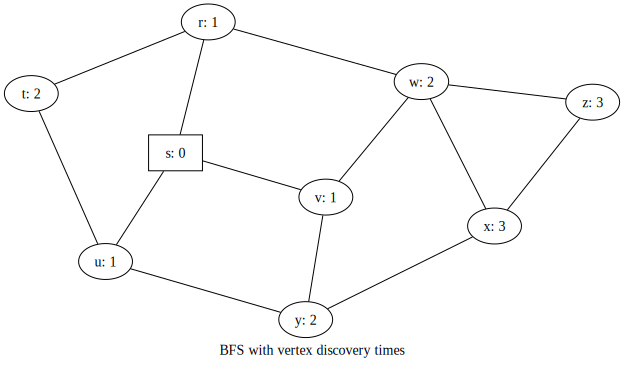

In [525]:
import graphviz as V

def draw(g: Graph, directed: bool, label: str="", engine: str="sfdp") -> V.Graph:
    # returned gv must be evaluated in the top level scope for it to render in the notebook
    gv = V.Digraph(engine=engine) if directed else V.Graph(engine=engine)
    gv.attr(label=label if label != "" else g.id)
    for v in g.getVV(): gv.node(v.id, label=f"{v.id}{f': {v.dis}' if v.dis != Infinity else ''}{f'/{v.fin}' if v.fin != -Infinity else ''}", shape=f"{'rectangle' if v.isRoot() else 'ellipse'}")
    er = {} # already drawn edges
    for e in g.getEE():
        if makeEid(e.v, e.u) not in er.keys(): # avoid drawing (v, u) if (u, v) has already been drawn
            gv.edge(e.u.id, e.v.id, label=f"{e.classification()} {e.weight()}")
            er[e.id] = e
    return gv

print(bg)
draw(bg, directed=False, label=f"{bg.id} with vertex discovery times")

The purpose of BFS is to discover a breadth-first tree (BFT) witihn the graph. So, let us implement `bft()`, our first application of the BFS algorithm. This function accepts a graph, runs `bfs()` on the graph, and extracts a BFT therefrom. After we extracted the BFT, we check that $|E| = |V| - 1$, as stated in Throrem B.2 *Properties of free trees* p.1169.

BFS†
  s: None 0
    [r,u,v]
  r: ^s 1
    [t,w]
  t: ^r 2
    []
  u: ^s 1
    [y]
  v: ^s 1
    []
  w: ^r 2
    [x,z]
  x: ^w 3
    []
  y: ^u 2
    []
  z: ^w 3
    []
  s-r:  
  r-t:  
  s-u:  
  s-v:  
  r-w:  
  w-x:  
  u-y:  
  w-z:  


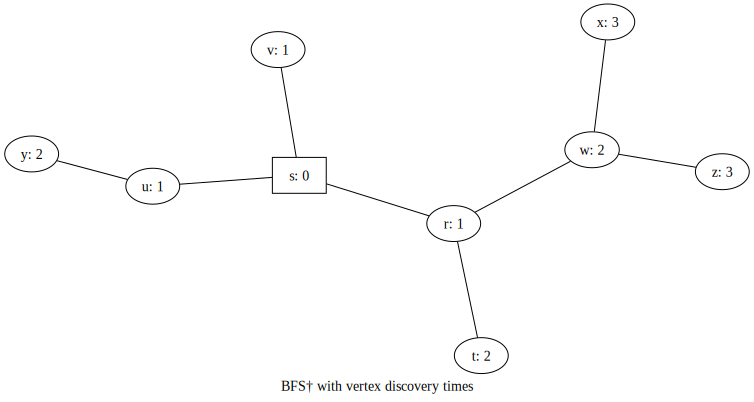

In [526]:
def bft(g: Graph, s: Vertex) -> Tree:
    g = bfs(g, s)
    t = Tree(f"{g.id}†")
    for u in g.getVV():
        if u == s or not u.isRoot(): t.insV(u)
    for u in t.getVV():
        if not u.isRoot():
            e = g.getE(makeEid(u.par, u))
            t.insE(e)
    return t

bs = bg.getV("s")
bt = bft(bg, bs)
assert(bt.numEE() == bt.numVV() - 1)
print(bt)
draw(bt, directed=False, label=f"{bt.id} with vertex discovery times")

## depth-first search

DFS discovers a depth-first forest (DFF) within the graph by staring from some vertex $u$ and following the outbound edge $(u, v)$ to the neighbour vertex $v$, then proceeding as far as possible before backtracking to $u$ and trying another neighbour, and continuing in this manner until all the vertices have been explored. See §20.3 *Depth-first search* p.563.

Since the point of DFS is to discover DFF, we implement `dff()`, as well. And since DFF is pointless without edge classification, we implement edge classification within `dfs()` as described on CLRS p.570. Our implementation of DFS, therefore, is slightly more complicated than that described on CLRS p.565, but this is a necessary, minor departure.

In [527]:
from functools import reduce

def dfs(g: Graph) -> Graph:
    def explore(u: Vertex) -> None:
        time[0] += 1
        # u discovered
        u.dis = time[0]
        u.col = VColor.Gray
        for v in g.adj(u):
            e = g.getE(makeEid(u, v))
            if v.col == VColor.Black: e.cls = EClass.F if u.dis < v.dis else EClass.C
            elif v.col == VColor.Gray: e.cls = EClass.B
            elif v.col == VColor.White:
                v.par = u
                e.cls = EClass.T
                explore(v)
        time[0] += 1
        # u finished
        u.fin = time[0]
        u.col = VColor.Black

    # reinitialize g
    g.init()
    # search g
    time = [0]
    for u in g.getVV():
        if u.col == VColor.White: explore(u)
    return g

def dff(g: Graph) -> Graph:
    g = dfs(g)
    f = Graph(f"{g.id}†")
    f.dupVV(g.vv)
    for v in f.getVV():
        if not v.isRoot():
            e = g.getE(makeEid(v.par, v))
            f.insE(e)
    #g = classify(f, g)
    return f

As we had done with BFS, we use the `explore()` recursive inner function to perform the search. CLRS uses the `time: int` global variable. We do not. Instead, we define a local `time: List[int]` in `dfs()`, and update it from within `explore()`. The inner function `explore()` can access variables defined in its outer function `dfs()`. This is called the *closure* property of functions. Python allows reading closure variables, but prohibits mutating them. But if a closure variable references an objects, the inner function may mutate the contents of the object but not the object reference itself. This is the case here: the `time` variable in `explore()` references a list object allocated in `dfs()`, so we may mutate the element `time[0]` but not `time` itself. This is an inelegant solution, but it allows us to follow the CLRS description.

### *CHECK dfs()*

We now test `dff()` using the directed graph shown in Figure 20.4 p.566. Since `dff()` calls `dfs()`, there is no need to test `dfs()` separately.

In [528]:
def makeDFG() -> Graph:
    vs = ["u", "v", "w", "x", "y", "z"]
    es = {  # directed edges
        "u": ["v", "x"],
        "v": ["y"],
        "w": ["y", "z"],
        "x": ["v"],
        "y": ["x"],
        "z": ["z"],
    }
    g = Graph("DFS")
    g.makeVE(vs, es)
    return g

dg = makeDFG()
df = dff(dg)

Now, we visualise graph `dg` with edges classified by DFF `df`.

DFS
  u: None 1/8
    [v,x]
  v: ^u 2/7
    [y]
  w: None 9/12
    [y,z]
  x: ^y 4/5
    [v]
  y: ^v 3/6
    [x]
  z: ^w 10/11
    [z]
  u-v:  T
  u-x:  F
  v-y:  T
  w-y:  C
  w-z:  T
  x-v:  B
  y-x:  T
  z-z:  B


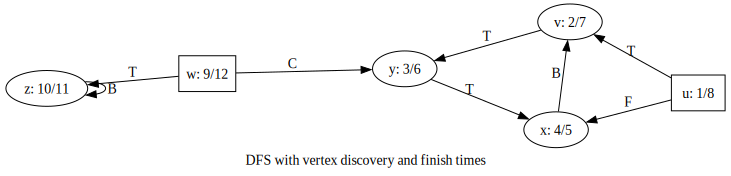

In [529]:
print(dg) # with classified edges
draw(dg, directed=True, label=f"{dg.id} with vertex discovery and finish times")

And we examine the DFF `df`, likewise.

DFS†
  u: None 1/8
    [v]
  v: ^u 2/7
    [y]
  w: None 9/12
    [z]
  x: ^y 4/5
    []
  y: ^v 3/6
    [x]
  z: ^w 10/11
    []
  u-v:  T
  y-x:  T
  v-y:  T
  w-z:  T


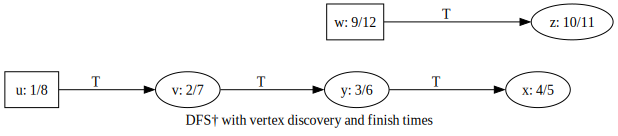

In [530]:
print(df)
draw(df, directed=True, label=f"{df.id} with vertex discovery and finish times")

# Applications of Elementary Graph Algorithms

CLRS Chapter 20 presents two applications: topological sort (TSort) and strongly connected components (SCC).

## topological sort

TSort applies DFS to a directed acyclic graph (DAG) to obtain a linear ordering of the vertices. Many simple tasks, like cooking and cleaning, to intricate processes, like surgical procedure and software compilation, depend on steps being performing in a particular order. A DAG can describe task dependencies, where vertices $u$ and $v$ are tasks and edges $(u, v)$ indicate that $u$ must be perfodelEd after $v$. TSort produces a sensible order of such tasks by applying DFS to the dag `sg` then sorting the vertices in the descending order of their finish times. See §20.4 *Topological sort* p.573.

In [531]:
def tsort(g: Graph) -> List[Vertex]:
    g = dfs(g)
    return sorted(g.getVV(), key=lambda u: u.fin, reverse=True)

### CHECK tsort()

We shall check `tsort()` to against the DAG shown in Figure 20.7 p.574. We use the `circo` circular layout engine to get a more compact display.

watch: None 17/18
undershorts: None 15/16
socks: None 13/14
shirt: None 9/12
tie: ^shirt 10/11
pants: None 5/8
shoes: ^pants 6/7
belt: None 1/4
jacket: ^belt 2/3


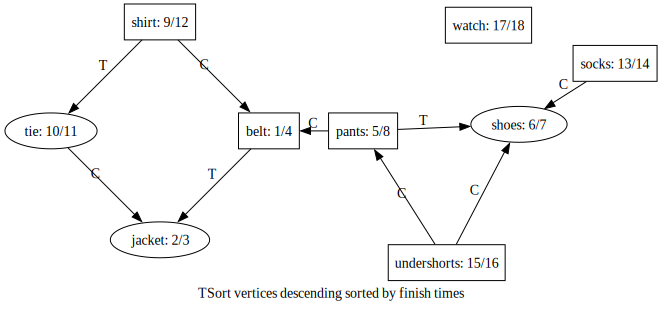

In [532]:
def makeTSG() -> Graph:
    vs = ["belt", "jacket", "pants", "shirt", "shoes", "socks", "tie", "undershorts", "watch"]
    es = { # directed edges
        "belt": ["jacket"],
        "jacket": [],
        "pants": ["belt", "shoes"],
        "shirt": ["belt", "tie"],
        "shoes": [],
        "socks": ["shoes"],
        "tie": ["jacket"],
        "undershorts": ["pants", "shoes"],
        "watch": [],
    }
    g = Graph("TSort")
    g.makeVE(vs, es)
    return g

sg = makeTSG()
sv = tsort(sg)
for u in sv: print(u)
draw(sg, directed=True, label=f"{sg.id} vertices descending sorted by finish times", engine="circo")

## strongly connected components

Strongly connected components (SCC) of a directed graph (digraph) are sets of vertices that are reacheable from each other. See Appendix B.4 *Graphs* pp.1164-1168. CLRS §20.5 *Strongly connected components* presents an algorithm that applies DFS twice to extract an SCC from a digraph. But first, we define the `Component` type, which is a `Vertex` that contains a set of strongly connected vertices. We also define the `makeCid()` utility function that forms the component's ID by merging the IDs of its constituent vertices.

In [533]:
class Component(Vertex):
    def __init__(self, id: ID):
        super().__init__(id)
        self.vv: VSet = {} # strongly connected vertices
    def init(self) -> None: self.__init__(self.id)

    def insVV(self, vv: List[Vertex]) -> None:
        for u in vv: self.vv[u.id] = u
    def getVV(self) -> List[Vertex]: return list(self.vv.values())

def makeCid(vv: List[Vertex]) -> ID: return "+".join([v.id for v in vv])

We we implement the SCC algorithm. To comput SCC according to the CLRS algorithm presented on p.577, we require two utility functions: `transpose()` that reverses the edges of a digraph, `sort()` that sorts the vertices by some attribute, and `contract()` that merges the strongly connected vertices into components by contracting the edges. `contract()` uses the DFF to contract its input graph. The contraction of an undirected graph is given on p.1168.

In [534]:
from typing import Callable

def scc(g: Graph) -> Graph:
    g = dfs(g)
    r = transpose(g)
    s = sort(r, key=lambda u: u.fin, reverse=True) # descending sort of vertices by finish times
    s = dfs(s)
    f = dff(s)
    return contract(g, f)

def transpose(g: Graph) -> Graph:
    # reverse edges
    r = Graph(f"{g.id}!")
    r.dupVV(g.vv)
    for e in g.getEE(): r.insE(Edge(e.v, e.u)) # flip (u, v) to (v, u)
    return r

def sort(g: Graph, key: Callable[[int], List[Vertex]], reverse: bool=False) -> Graph:
    # sort vertices
    s = Graph(f"{g.id}$")
    for u in sorted(g.getVV(), key=key, reverse=reverse): s.insV(u) # sorted vertices
    s.dupEE(g.ee)
    return s

def contract(g: Graph, f: Graph) -> Graph:
    # contract DFS g using DFF f
    def scv(u: Vertex) -> List[Vertex]:
        aa = f.adj(u) # vertex u's adjacent vertices in DFF f
        if aa == []: return [] # u is a leaf
        v = aa[0] # there is only one adjacent vertex v in DFF f
        return [v, *scv(v)]
    
    c = Graph(f"{g.id}₵") # SCC c
    # create vertices of SCC c
    for r in [v for v in g.getVV() if v.isRoot()]: # for each root vertex r in DFS g
        vv = [r, *scv(r)] # strongly connected vertices rooted at vertex r
        x = Component(makeCid(vv)) # create component x by merging strongly connected vertices vv
        x.insVV(vv)
        c.insV(x) # insert component x into SCC c
    # create edges of SCC c
    cc = c.getVV() # components of SCC c
    for x in cc: # for each component x in SCC c
        aa: VSet = {} # adjacent vertices of component x in DFS g
        vv = x.getVV() # constituent vertices of component x
        for u in vv: # for each constituent vertex u of component x
            for v in [a for a in g.adj(u) if a not in vv]: aa[v.id] = v # for each (u, v) leaving component x
        for a in aa.values(): # for each adjacent vertex a of component x
            for y in [b for b in cc if b != x]: # for every other component y in SCC c
                if a in y.getVV(): # component y is adjacent to component x
                    c.insE(Edge(x, y)) # insert edge (x, y) into SCC c
    return c

### CHECK scc()

We now check `scc()` against the digraph show in Figure 20.9 p.577.

SCC₵
  a+e+b: None 
    [g+f,c+d]
  c+d: None 
    [g+f,h]
  g+f: None 
    [h]
  h: None 
    []
  a+e+b-g+f:  
  a+e+b-c+d:  
  c+d-g+f:  
  c+d-h:  
  g+f-h:  


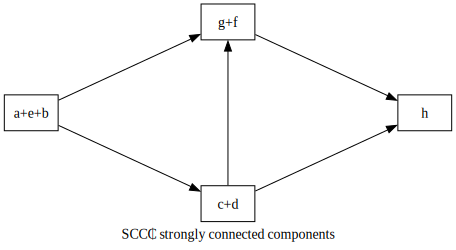

In [536]:
def makeSCG() -> Graph:
    vs = ["a", "b", "c", "d", "e", "f", "g", "h"]
    es = { # directed edges
        "a": ["b"],
        "b": ["c", "e", "f"],
        "c": ["d", "g"],
        "d": ["c", "h"],
        "e": ["a", "f"],
        "f": ["g"],
        "g": ["f", "h"],
        "h": ["h"],
    }
    g = Graph("SCC")
    g.makeVE(vs, es)
    return g

cg = makeSCG()
cg = scc(cg)
print(cg)
draw(cg, directed=True, label=f"{cg.id} strongly connected components")

# Conclusion

In this notebook, we implemented the graph data structure, the elementary graph algorithms, and the two graph applications described in CLRS Chapter 20. We may now proceed to more advanced graph algorithms.